In [1]:
!mkdir /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/residual_full_mixup/outputs_residual_full_mixup

mkdir: cannot create directory ‘/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/residual_full_mixup/outputs_residual_full_mixup’: File exists


In [1]:
OUTPUT_FOLDER='/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/residual_full_mixup/outputs_residual_full_mixup'

In [2]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
DATA_FOLDER ='/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/'
SOURCE_DATA_FOLDER = DATA_FOLDER  + "SleepSource/"
LEADERBOARD_TARGET_DATA_FOLDER = DATA_FOLDER + "LeaderboardSleep/sleep_target/"
LEADERBOARD_TEST_DATA_FOLDER = DATA_FOLDER + "LeaderboardSleep/testing/"
FINAL_TARGET_DATA_FOLDER = DATA_FOLDER + "finalSleep/sleep_target/"
FINAL_TEST_DATA_FOLDER = DATA_FOLDER + "finalSleep/testing/"

## data_utils

In [4]:
import mne

In [5]:
def load_data(data_folder, load_labels=True):
    fn_list = sorted(os.listdir(data_folder))
    print(f"Loading data from folder: {data_folder} ({len(fn_list)} files) - Load labels {load_labels}")

    data_map = {}
    subject_list = []
    sample_counter = 0

    for fn in tqdm(fn_list):
        if fn.endswith("X.npy"):
            code = fn.split("_")[1][:-4]
        elif fn == "headerInfo.npy":
            meta = np.load(data_folder + fn, allow_pickle=True)
            print(meta)
            continue
        else:
            continue

        eeg = np.load(data_folder + fn, allow_pickle=True)

        if load_labels:
            label_fn = fn.replace("X", "y")
            label = np.load(data_folder + label_fn, allow_pickle=True)
        else:
            label = None

        s_part, r_part = code.split("r")
        subject = int(s_part[1:])
        repetition = int(r_part[:-1])
        
        subject_list.append(subject)

        if subject not in data_map.keys():
            data_map[subject] = {}

        data_map[subject][repetition] = {"eeg": eeg, "label": label}
        sample_counter += len(eeg)

    subject_list = np.unique(subject_list)
    print(f"Loaded total {sample_counter} samples for subjects: {subject_list}")
    return data_map, subject_list

### preprocessing

In [6]:
def prepare_window_data(data, subject_list=None):
    window_data = []
    window_labels = []

    if subject_list is None:
        subject_list = data.keys()

    for s in tqdm(subject_list):
        for r in data[s].keys():
            eeg = data[s][r]["eeg"]
            label = data[s][r]["label"]

            window_data.extend(eeg)
            
            if label is not None:
                window_labels.extend(label)

    return window_data, window_labels

In [7]:
def print_stats(desc, data):
    print(f"{desc} mean: {np.mean(data)}, std: {np.std(data)}, min: {np.min(data)}, max: {np.max(data)}")

def normalize(data, mean_value, std_value, desc=""):
    data = np.array(data)
    data = (data - mean_value) / std_value
    print_stats(desc, data)
    return list(data)

def filter_freq(data, f_min, f_max, FS):
    return mne.filter.filter_data(np.array(data, dtype=np.float64), FS, f_min, f_max, method="iir", verbose=False)

def downsample(data, FS, FS_new):
    return mne.filter.resample(data, down=FS/FS_new)

## runner_utils

In [8]:
import os
import torch
import random
import numpy as np

def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## dataset

In [9]:
def add_noise(data):
    if np.random.rand() > 0.5:
        data += np.random.normal(0, 0.01, (data.shape))
    return data

def handle_mixup(idx, data, label, mixup_data, supervised_mixup_data, mixup_idx, mixup_rate):
    mixup_data = mixup_data
    # use supervised mixup data if available
    if supervised_mixup_data is not None:
        mixup_data = supervised_mixup_data[label]
    # if mixup condition is set and id is not mixable
    if mixup_idx is not None and not mixup_idx[idx]:
        mixup_data = None
    # do mixup if available
    if mixup_data is not None:
        data = mixup(data, mixup_data, mixup_rate)
    
    return data

def mixup(data, mixup_data, mixup_rate):
    mixup_rate = np.random.rand() * mixup_rate
    idx = np.random.randint(0, len(mixup_data))
    return (1-mixup_rate)*data + mixup_rate*mixup_data[idx]

In [10]:
class SleepDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None, mixup_data=None, supervised_mixup_data=None, mixup_idx=None, mixup_rate=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        
        self.supervised_mixup_data = supervised_mixup_data
        self.mixup_data = mixup_data
        self.mixup_idx = mixup_idx
        self.mixup_rate = mixup_rate

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]

        if self.labels is not None:
            label = self.labels[idx].astype(np.int64)
        else:
            label = -1
        
        ### DATA AUGMENTATION ###
        data = handle_mixup(idx, data, label, self.mixup_data, self.supervised_mixup_data, self.mixup_idx, self.mixup_rate)

        if self.transform:
            data = self.transform(data)
        ### END DATA AUGMENTATION ###

        data = data.astype(np.float32)

        return {"eeg": data, "label": label}

## runner

### Focal loss

In [11]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    """ Focal loss with optional label smoothing.

    Calculates mean focal loss over given data with optional label smoothing.

    Attributes
    ----------
        alpha: int = 1
        gamma: int = 2
        logits: bool = True
        reduce: bool = True
        ls: float = None
            label smoothing ratio, if None label smoothing will not be applied
        classes: int = None
            number of classes required for label smoothing
    """

    def __init__(
        self,
        alpha: int = 1,
        gamma: int = 2,
        logits: bool = True,
        reduce: bool = True,
        ls: float = 0.05,
        classes: int = 6,
    ):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce
        self.ls = ls
        self.classes = classes

    def forward(self, inputs, targets):
        targets = F.one_hot(targets, num_classes=6)

        if self.ls is not None:
            targets = (1 - self.ls) * targets + self.ls / self.classes

        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction="none")

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

### VAT

In [12]:
# implementation from: https://github.com/lyakaap/VAT-pytorch

import contextlib
import torch
import torch.nn as nn
import torch.nn.functional as F


@contextlib.contextmanager
def _disable_tracking_bn_stats(model):

    def switch_attr(m):
        if hasattr(m, 'track_running_stats'):
            m.track_running_stats ^= True
            
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)


def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-8
    return d


class VATLoss(nn.Module):

    def __init__(self, xi=10.0, eps=1.0, ip=1):
        """VAT loss
        :param xi: hyperparameter of VAT (default: 10.0)
        :param eps: hyperparameter of VAT (default: 1.0)
        :param ip: iteration times of computing adv noise (default: 1)
        """
        super(VATLoss, self).__init__()
        self.xi = xi
        self.eps = eps
        self.ip = ip

    def forward(self, model, x):
        with torch.no_grad():
            pred = F.softmax(model(x), dim=1)

        # prepare random unit tensor
        d = torch.rand(x.shape).sub(0.5).to(x.device)
        d = _l2_normalize(d)

        with _disable_tracking_bn_stats(model):
            # calc adversarial direction
            for _ in range(self.ip):
                d.requires_grad_()
                pred_hat = model(x + self.xi * d)
                logp_hat = F.log_softmax(pred_hat, dim=1)
                adv_distance = F.kl_div(logp_hat, pred, reduction='batchmean')
                adv_distance.backward()
                d = _l2_normalize(d.grad)
                model.zero_grad()
    
            # calc LDS
            r_adv = d * self.eps
            pred_hat = model(x + r_adv)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            lds = F.kl_div(logp_hat, pred, reduction='batchmean')

        return lds

### train, validate, predict

In [13]:
import torch
import numpy as np

def train_epoch(args, model, loader, criterion, optimizer, scheduler, epoch):
    losses = []
    targets_all = []
    outputs_all = []

    vat_loss = VATLoss(xi=10.0, eps=1.0, ip=1)

    model.train()
    t = tqdm(loader)

    for i, sample in enumerate(t):
        optimizer.zero_grad()

        eeg = sample["eeg"].to(args.device)
        target = sample["label"].to(args.device)

        lds = vat_loss(model, eeg)
        output = model(eeg)
        loss = criterion(output, target) + args.alpha * lds
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        losses.append(loss.item())
        
        target = target.cpu().numpy()
        output = output.detach().cpu().numpy()

        targets_all.extend(target)
        outputs_all.extend(output)

        output_loss = np.mean(losses)
        output_score = np.mean(targets_all == np.argmax(outputs_all, axis=1))

        t.set_description(
            f"Epoch {epoch}/{args.epochs} - Train loss: {output_loss:0.4f}, score: {output_score:0.4f}"
        )

    return targets_all, outputs_all, output_score, output_loss


def validate(args, model, loader, criterion, desc="Valid"):
    losses = []
    targets_all = []
    outputs_all = []

    t = tqdm(loader)
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(t):
            eeg = sample["eeg"].to(args.device)
            target = sample["label"].to(args.device)

            output = model(eeg)
            loss = criterion(output, target)

            losses.append(loss.item())
            targets_all.extend(target.cpu().numpy())
            outputs_all.extend(output.detach().cpu().numpy())

            output_loss = np.mean(losses)
            output_score = np.mean(targets_all == np.argmax(outputs_all, axis=1))

            t.set_description(
                f"\t  - {desc} loss: {output_loss:0.4f}, score: {output_score:0.4f}"
            )

    return targets_all, outputs_all, output_score, output_loss


def predict(args, model, loader):
    outputs_all = []

    t = tqdm(loader)
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(t):
            eeg = sample["eeg"].to(args.device)

            output = model(eeg)
            outputs_all.extend(output.detach().cpu().numpy())
    return outputs_all

## model

In [14]:
import torch
import torch.nn as nn

In [15]:
# def get_linear(in_features, out_features):
#     return nn.utils.weight_norm(nn.Linear(in_features, out_features))

# class BaseEEGClassifier(nn.Module):
#     def __init__(self):
#         super(BaseEEGClassifier, self).__init__()

#         N_channels = [64, 128, 256]
        
#         self.c1 = nn.Sequential(nn.Conv1d(2, N_channels[0], 401, 50, 200),
#                                 nn.BatchNorm1d(N_channels[0]),
#                                 nn.SiLU(),
#                                 nn.Dropout(0.2),
#                                 nn.MaxPool1d(3,2,1),
#                                 nn.Conv1d(N_channels[0], N_channels[1], 7, 2, 3),
#                                 nn.BatchNorm1d(N_channels[1]),
#                                 nn.SiLU(),
#                                 nn.Dropout(0.2),
#                                 nn.Conv1d(N_channels[1], N_channels[2], 5, 1, 2),
#                                 nn.BatchNorm1d(N_channels[2]),
#                                 nn.AdaptiveMaxPool1d(1),
#                                 )
        
#         self.c2 = nn.Sequential(nn.Conv1d(2, N_channels[0], 51, 5, 25),
#                                 nn.BatchNorm1d(N_channels[0]),
#                                 nn.SiLU(),
#                                 nn.Dropout(0.2),
#                                 nn.MaxPool1d(9,3,4),
#                                 nn.Conv1d(N_channels[0], N_channels[1], 7, 2, 3),
#                                 nn.BatchNorm1d(N_channels[1]),
#                                 nn.SiLU(),
#                                 nn.Conv1d(N_channels[1], N_channels[2], 5, 1, 2),
#                                 nn.BatchNorm1d(N_channels[2]),
#                                 nn.AdaptiveMaxPool1d(1),
#                                 )
        
#         self.linear = get_linear(N_channels[2]*2, 1024)
#         self.act = nn.SiLU()
#         self.dropout = nn.Dropout(0.2)
        
#     def forward(self, x):
#         x1 = self.c1(x)
#         x2 = self.c2(x)

#         x = torch.cat([x1, x2], dim=1)
#         x = x.flatten(1,-1)
#         x = self.act(x)
#         x = self.dropout(x)
#         x = self.linear(x)
#         x = self.act(x)
#         return x

# class EEGClassifier(nn.Module):
#     def __init__(self):
#         super(EEGClassifier, self).__init__()

#         self.base = BaseEEGClassifier()
#         self.fc = get_linear(1024, 6)

#     def features(self, x):
#         x = self.base(x)
#         return x

#     def forward(self, x):
#         x = self.features(x)
#         x = self.fc(x)
#         return x

In [16]:
# !pip install braindecode

In [17]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from braindecode.models import USleep

# def get_linear(in_features, out_features):
#     return nn.utils.weight_norm(nn.Linear(in_features, out_features))

# class AttentionBlock(nn.Module):
#     def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.1):
#         super().__init__()
#         self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
#         self.norm1 = nn.LayerNorm(embed_dim)
#         self.norm2 = nn.LayerNorm(embed_dim)
#         self.ff = nn.Sequential(
#             nn.Linear(embed_dim, hidden_dim),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, embed_dim),
#             nn.Dropout(dropout)
#         )

#     def forward(self, x):
#         attn_output, _ = self.attention(x, x, x)
#         x = self.norm1(x + attn_output)
#         x = self.norm2(x + self.ff(x))
#         return x

# class BaseEEGClassifier(nn.Module):
#     def __init__(self, n_chans=2, sfreq=100, depth=8, n_time_filters=10, 
#                  complexity_factor=2.0, n_outputs=5, input_window_seconds=30):
#         super(BaseEEGClassifier, self).__init__()
        
#         self.usleep = USleep(
#             n_chans=n_chans,
#             sfreq=sfreq,
#             depth=depth,
#             n_time_filters=n_time_filters,
#             complexity_factor=complexity_factor,
#             with_skip_connection=True,
#             n_outputs=n_outputs,
#             input_window_seconds=input_window_seconds,
#         )
        
#         self.attention = nn.MultiheadAttention(n_outputs, num_heads=1, batch_first=True)
        
#         self.fc = nn.Sequential(
#             nn.Linear(n_outputs, n_outputs * 2),
#             nn.GELU(),
#             nn.Dropout(0.3),
#             nn.Linear(n_outputs * 2, n_outputs * 2),
#             nn.GELU(),
#             nn.Dropout(0.3),
#             nn.Linear(n_outputs * 2, n_outputs)
#         )

#     def forward(self, x):
#         x = self.usleep(x)
#         # Reshape x to (batch_size, seq_len, n_outputs)
#         if x.dim() == 2:
#             x = x.unsqueeze(1)
#         elif x.dim() == 3:
#             x = x.transpose(1, 2)
        
#         # Apply attention
#         x, _ = self.attention(x, x, x)
        
#         # Global average pooling
#         x = x.mean(dim=1)
        
#         x = self.fc(x)
#         return x

# class EEGClassifier(nn.Module):
#     def __init__(self):
#         super(EEGClassifier, self).__init__()
#         self.base = BaseEEGClassifier()
#         self.fc = nn.Linear(5, 6)  # Assuming the base model outputs 5 features

#     def forward(self, x):
#         x = self.base(x)
#         x = self.fc(x)
#         return x

# # Example usage
# model = EEGClassifier()
# print(model)

In [18]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CNNBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
#         super(CNNBlock, self).__init__()
#         self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
#         self.bn = nn.BatchNorm1d(out_channels)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         return self.relu(self.bn(self.conv(x)))

# class TransformerEncoderLayer(nn.Module):
#     def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
#         super(TransformerEncoderLayer, self).__init__()
#         self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
#         self.linear1 = nn.Linear(d_model, dim_feedforward)
#         self.dropout = nn.Dropout(dropout)
#         self.linear2 = nn.Linear(dim_feedforward, d_model)
#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.dropout1 = nn.Dropout(dropout)
#         self.dropout2 = nn.Dropout(dropout)
#         self.activation = F.relu

#     def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
#         src2 = self.self_attn(src, src, src, attn_mask=src_mask,
#                               key_padding_mask=src_key_padding_mask,
#                               is_causal=is_causal)[0]
#         src = src + self.dropout1(src2)
#         src = self.norm1(src)
#         src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
#         src = src + self.dropout2(src2)
#         src = self.norm2(src)
#         return src

# class EEGClassifier(nn.Module):
#     def __init__(self, n_channels=2, n_time=3000, n_classes=6):
#         super(EEGClassifier, self).__init__()
        
#         # CNN layers
#         self.cnn_layers = nn.Sequential(
#             CNNBlock(n_channels, 16, kernel_size=7, stride=2, padding=3),
#             CNNBlock(16, 32, kernel_size=5, stride=2, padding=2),
#             CNNBlock(32, 64, kernel_size=3, stride=2, padding=1),
#             CNNBlock(64, 128, kernel_size=3, stride=2, padding=1)
#         )
        
#         # Calculate the output size of CNN layers
#         with torch.no_grad():
#             dummy_input = torch.zeros(1, n_channels, n_time)
#             dummy_output = self.cnn_layers(dummy_input)
#             self.cnn_output_size = dummy_output.size(1) * dummy_output.size(2)
        
#         # Transformer layers
#         encoder_layer = TransformerEncoderLayer(d_model=128, nhead=8)
#         self.transformer_layers = nn.TransformerEncoder(encoder_layer, num_layers=3)
        
#         # MLP layers
#         self.mlp = nn.Sequential(
#             nn.Linear(self.cnn_output_size, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, n_classes)
#         )

#     def forward(self, x):
#         # CNN
#         x = self.cnn_layers(x)
        
#         # Prepare for Transformer (seq_len, batch_size, d_model)
#         x = x.permute(2, 0, 1)
        
#         # Transformer
#         x = self.transformer_layers(x)
        
#         # Prepare for MLP
#         x = x.permute(1, 0, 2)
#         x = x.reshape(x.size(0), -1)
        
#         # MLP
#         x = self.mlp(x)
        
#         return x

# # Example usage
# model = EEGClassifier(n_channels=2, n_time=3000, n_classes=6)
# print(model)

# # Test with random input
# x = torch.randn(32, 2, 3000)  # (batch_size, n_channels, n_time)
# output = model(x)
# print(f"Output shape: {output.shape}")

In [19]:
# try:
#     import torchkeras
#     print("torchkeras imported successfully")
# except ImportError as e:
#     print(f"ImportError: {e}")


In [20]:
# from torchkeras import plot_model
# # Specify the output directory

# os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# # Plot and save the model architecture
# plot_path = os.path.join(OUTPUT_FOLDER, 'simple_cnn_architecture.png')
# plot_model(model, plot_path, show_shapes=True)

# print(f"Model architecture has been saved as an image at {plot_path}.")

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.se = SEBlock(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class EEGClassifier(nn.Module):
    def __init__(self, eeg_channel=2, n_time=3000, n_classes=6, dropout=0.5):
        super(EEGClassifier, self).__init__()
        
        self.conv1 = nn.Conv1d(eeg_channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        
        # Calculate the output size after convolutions and pooling
        self.conv_output_size = n_time // 16  # Due to initial stride=2, maxpool, and two stride=2 in layers
        
        self.gru = nn.GRU(256, 128, num_layers=2, batch_first=True, bidirectional=True, dropout=dropout)
        
        self.attn = nn.MultiheadAttention(256, num_heads=8, dropout=dropout)
        
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, n_classes)
        )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Prepare for GRU (batch, seq_len, features)
        x = x.permute(0, 2, 1)
        
        # GRU
        x, _ = self.gru(x)
        
        # Self-attention
        x = x.permute(1, 0, 2)  # (seq_len, batch, features)
        x, _ = self.attn(x, x, x)
        x = x.permute(1, 0, 2)  # (batch, seq_len, features)
        
        # Global average pooling
        x = x.mean(dim=1)
        
        # Final classification
        x = self.fc(x)
        
        return x

# Example usage
model = EEGClassifier(eeg_channel=2, n_time=3000, n_classes=6)
print(model)

# Test with random input
x = torch.randn(32, 2, 3000)  # (batch_size, n_channels, n_time)
output = model(x)
print(f"Output shape: {output.shape}")

EEGClassifier(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool1d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=False)
          (3): Sigmoid(

## main

In [22]:
import seaborn as sns
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix

### args

In [23]:
import json

class base_args(object):
    def __init__(self, model_name, seed=42):
        self.model_name = model_name
        self.seed = seed

        self.lr = 1e-3
        self.epochs = 5
        self.batch_size = 120
        self.num_workers = 2
        self.device = ('cuda' if torch.cuda.is_available() else 'cpu')
        self.alpha = 0.01
        self.phase = "base"

    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)

    def get_model_name(self):
        return f"{self.model_name}_{self.phase}"

### experiment helper functions

In [24]:
def train_model(args, model, 
          train_data, train_labels, 
          valid_data, valid_labels, 
          train_weights=None, sample_rate=None, 
          use_scheduler=True,
          history = {"Train": {"Score": [], "Loss": []}, 
                     "Valid": {"Score": [], "Loss": []}},
          mixup_data=None, supervised_mixup_data=None, mixup_idx=None, mixup_rate=None):
    
    train_dataset = SleepDataset(train_data, train_labels, transform=add_noise, 
                                 mixup_data=mixup_data, supervised_mixup_data=supervised_mixup_data, 
                                 mixup_idx=mixup_idx, mixup_rate=mixup_rate)
    
    if train_weights is not None:
        train_sampler = WeightedRandomSampler(weights = train_weights, num_samples=int(len(train_labels)*sample_rate))
        train_loader = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, sampler=train_sampler, drop_last=True)
    else:
        train_loader = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=True, drop_last=True)

    model = model.to(args.device)
    criterion = FocalLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=5e-4)

    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
                        optimizer,
                        max_lr=args.lr,
                        epochs=args.epochs,
                        steps_per_epoch=len(train_loader),
                        div_factor=10, 
                        final_div_factor=10,
                        pct_start=0.1,
                        anneal_strategy="cos",
                    )
    else:
        scheduler = None
    
    for epoch in range(1, args.epochs+1):
        _, _, train_score, train_loss = train_epoch(args, model, train_loader, criterion, optimizer, scheduler, epoch)
        _, _, valid_score, valid_loss = validate_model(args, model, valid_data, valid_labels, show_plot=False)

        history["Train"]["Loss"].append(train_loss)
        history["Train"]["Score"].append(train_score)
        history["Valid"]["Loss"].append(valid_loss)
        history["Valid"]["Score"].append(valid_score)

    torch.save(model.state_dict(), f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt")


def validate_model(args, model, valid_data, valid_labels, desc="Target", show_plot=True):
    criterion = FocalLoss()

    valid_dataset = SleepDataset(valid_data, valid_labels)
    valid_loader = DataLoader(valid_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)
    targets_all, outputs_all, output_score, output_loss = validate(args, model, valid_loader, criterion, desc)
    
    if show_plot:
        cf_mat = confusion_matrix(targets_all, np.argmax(outputs_all, axis=1), normalize="true")
        plt.figure()
        sns.heatmap(cf_mat, annot=True)
        plt.show()

    return targets_all, outputs_all, output_score, output_loss


def get_prediction(args, model, data):
    model.to(args.device)
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    
    dataset = SleepDataset(data, None)
    loader = DataLoader(dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)

    output = predict(args, model, loader)
    return output


def ensemble(args_array, dataset_name="test", phase=None):
    ensemble_output = None

    for args in args_array:
        if phase is None:
            fn = f"{OUTPUT_FOLDER}{args.get_model_name()}-{dataset_name}_output.npy"
        else:
            fn = f"{OUTPUT_FOLDER}{args.model_name}_{phase}-{dataset_name}_output.npy"
            
        output = np.load(fn)
        if ensemble_output is None:
            ensemble_output = output
        else:
            ensemble_output += output
    
    return ensemble_output
    

def predict_and_save(args, model, target_data, test_data):
    target_output = get_prediction(args, model, target_data)
    np.save(f"{OUTPUT_FOLDER}{args.get_model_name()}-target_output.npy", target_output)
    
    test_output = get_prediction(args, model, test_data)
    np.save(f"{OUTPUT_FOLDER}{args.get_model_name()}-test_output.npy", test_output)


def plot_history(history):
    fig, axes = plt.subplots(2,1, figsize=(22,6))
    axes[0].plot(history["Train"]["Score"], label="Train score")
    axes[0].plot(history["Valid"]["Score"], label="Valid score")
    axes[0].legend()
    axes[1].plot(history["Train"]["Loss"], label="Train loss")
    axes[1].plot(history["Valid"]["Loss"], label="Valid loss")
    axes[1].legend()
    fig.show()

### competition data loaders

In [25]:
def get_phase_1_data():
    source_data, source_subjects = load_data(SOURCE_DATA_FOLDER)
    source_data, source_labels = prepare_window_data(source_data, source_subjects)
    # calculate stats of source data and normalize it
    source_data = np.array(source_data)
    source_mean = np.mean(source_data)
    source_std = np.std(source_data)
    source_data = (source_data - source_mean) / source_std
    print(f"Source mean: {source_mean}, std: {source_std}, min: {np.min(source_data)}, max: {np.max(source_data)}")
    source_data  = list(source_data)
    # load and normalize target data
    lb_target_data, lb_target_subjects = load_data(LEADERBOARD_TARGET_DATA_FOLDER)
    lb_target_data, lb_target_labels = prepare_window_data(lb_target_data, lb_target_subjects)
    lb_target_data = normalize(lb_target_data, source_mean, source_std, "Leadeboard target")
    # load and normalize test data
    lb_test_data, lb_test_subjects = load_data(LEADERBOARD_TEST_DATA_FOLDER, load_labels=False)
    lb_test_data, lb_test_labels = prepare_window_data(lb_test_data, lb_test_subjects)
    lb_test_data = normalize(lb_test_data, source_mean, source_std, "Leadeboard test")

    return source_data, source_labels, lb_target_data, lb_target_labels, lb_test_data, lb_test_data


def get_phase_2_data():
    source_data, source_subjects = load_data(SOURCE_DATA_FOLDER)
    source_data, source_labels = prepare_window_data(source_data, source_subjects)
    # add target data from phase 1 to source data
    lb_target_data, lb_target_subjects = load_data(LEADERBOARD_TARGET_DATA_FOLDER)
    lb_target_data, lb_target_labels = prepare_window_data(lb_target_data, lb_target_subjects)
    # source_data += lb_target_data
    # source_labels += lb_target_labelsOUTPUT_FOLDER
    # calculate stats and normalize
    source_data = np.array(source_data)
    source_mean = np.mean(source_data)
    source_std = np.std(source_data)
    source_data = (source_data - source_mean) / source_std
    print(f"Source mean: {source_mean}, std: {source_std}, min: {np.min(source_data)}, max: {np.max(source_data)}")
    source_data  = list(source_data)
    # load test data from phase 1 and normalize it
    lb_test_data, lb_test_subjects = load_data(LEADERBOARD_TEST_DATA_FOLDER, load_labels=False)
    lb_test_data, lb_test_labels = prepare_window_data(lb_test_data, lb_test_subjects)
    lb_test_data = normalize(lb_test_data, source_mean, source_std, "Leadeboard test")
    # load and normalize target data
    fn_target_data, fn_target_subjects = load_data(FINAL_TARGET_DATA_FOLDER)
    fn_target_data, fn_target_labels = prepare_window_data(fn_target_data, fn_target_subjects)
    fn_target_data += lb_target_data
    fn_target_labels += lb_target_labels
    fn_target_data = normalize(fn_target_data, source_mean, source_std, "Target")
    # load and normalize test data
    fn_test_data, fn_test_subjects = load_data(FINAL_TEST_DATA_FOLDER, load_labels=False)
    fn_test_data, fn_test_labels = prepare_window_data(fn_test_data, fn_test_subjects)
    fn_test_data = normalize(fn_test_data, source_mean, source_std, "Final test")

    return source_data, source_labels, fn_target_data, fn_target_labels, fn_test_data, fn_test_data

### training pipeline function

In [26]:
def supervised_run(args, model, train_data, train_labels, target_data, target_labels, test_data, mixup_data=None, supervised_mixup_data=None):
    print(args.toJSON())

    history = {"Train": {"Score": [], "Loss": []}, 
               "Valid": {"Score": [], "Loss": []}}

    ############################
    ### USE ONLY SOURCE DATA ###
    ############################
    args.phase = "base"

    train_model(args, model, 
                train_data, train_labels, 
                target_data, target_labels, 
                mixup_data=mixup_data, mixup_rate=0.,
                history=history)
    # validate
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    print("\n###### PHASE 1 FINISHED ##########")
    validate_model(args, model, target_data, target_labels, "Target")
    # make predictions and save results
    predict_and_save(args, model, target_data, test_data)


    ##############################
    ### SOURCE DATA WITH SUPERVISED MIXUP ###
    ##############################
    args.lr = 1e-4
    args.epochs = 10
    args.phase = "mixup"

    train_model(args, model, 
                train_data, train_labels, 
                target_data, target_labels, 
                supervised_mixup_data=supervised_mixup_data, mixup_rate=1,
                history=history)
    # validate
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    print("\n###### PHASE 2 FINISHED ########OUTPUT_FOLDER##")
    validate_model(args, model, target_data, target_labels, "Target")
    # make predictions and save results
    predict_and_save(args, model, target_data, test_data)

    ###############################
    ### FINETUNE ON TARGET DATA WITH MIXED UP SOURCE ###
    ###############################
    args.lr = 1e-3
    args.epochs = 20
    args.phase = "mixup_finetuned"
    # prepare extended train data with sampler settings
    extended_train_data = train_data + target_data
    extended_train_labels = train_labels + target_labels
    train_weights = [0.25] * len(train_labels) + [0.75] * len(target_labels)
    mixup_idx = [True] * len(train_labels) + [False] * len(target_labels)
    train_sample_rate = 0.5

    train_model(args, model, 
                extended_train_data, extended_train_labels,
                target_data, target_labels,
                train_weights = train_weights, sample_rate=train_sample_rate,
                mixup_data=mixup_data, mixup_idx=mixup_idx, mixup_rate=1,
                use_scheduler=True, history=history)
    
    # validate
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    print("\n###### PHASE 3 FINISHED ##########")
    validate_model(args, model, target_data, target_labels, "Target")
    # make predictions and save results
    predict_and_save(args, model, target_data, test_data)
    # plot training history
    plot_history(history)

### training

In [27]:
source_data, source_labels, target_data, target_labels, test_data, mixup_data = get_phase_1_data()

Loading data from folder: /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/SleepSource/ (158 files) - Load labels True


  0%|                                                   | 0/158 [00:00<?, ?it/s]

<Info | 8 non-empty values
 bads: []
 ch_names: Fpz-Cz, Pz-Oz
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1991-09-26 15:00:00 UTC
 nchan: 2
 projs: []
 sfreq: 100.0 Hz
 subject_info: 2 items (dict)
>


100%|█████████████████████████████████████████| 158/158 [00:38<00:00,  4.07it/s]


Loaded total 90545 samples for subjects: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2471.38it/s]


Source mean: -2.175762164676705e-07, std: 1.6836217270029333e-05, min: -14.7172265485441, max: 12.426637935405019
Loading data from folder: /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/LeaderboardSleep/sleep_target/ (25 files) - Load labels True


  0%|                                                    | 0/25 [00:00<?, ?it/s]

<Info | 8 non-empty values
 bads: []
 ch_names: Fpz-Cz, Pz-Oz
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1990-03-13 15:09:00 UTC
 nchan: 2
 projs: []
 sfreq: 100.0 Hz
 subject_info: 2 items (dict)
>


100%|███████████████████████████████████████████| 25/25 [00:06<00:00,  3.90it/s]


Loaded total 15442 samples for subjects: [0 1 2 3 4 5]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 4248.11it/s]


Leadeboard target mean: 0.038902552623313796, std: 1.0560441229752748, min: -11.688042547053058, max: 12.010867582259191
Loading data from folder: /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/LeaderboardSleep/testing/ (25 files) - Load labels False


100%|███████████████████████████████████████████| 25/25 [00:10<00:00,  2.38it/s]


Loaded total 25748 samples for subjects: [ 6  7  8  9 10 11 12 13 14 15 16 17]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 3328.81it/s]


Leadeboard test mean: 0.014119353426048422, std: 0.8645048345254686, min: -11.985021370728651, max: 11.832680288053835


In [28]:
tmp = np.array(target_data)
supervised_mixup_data = {}
for c in np.unique(target_labels):
    supervised_mixup_data[c] = tmp[target_labels == c]
    print(c, np.shape(supervised_mixup_data[c]))

del tmp

0 (6010, 2, 3000)
1 (1672, 2, 3000)
2 (5035, 2, 3000)
3 (704, 2, 3000)
4 (414, 2, 3000)
5 (1607, 2, 3000)


In [30]:
import numpy as np

# Assuming y_train is your array
unique_classes, counts = np.unique(target_labels, return_counts=True)

# Calculating the total number of entries
total_entries = counts.sum()

# Creating a dictionary to show class: percentage of entries
class_percentages = {cls: (count / total_entries) * 100 for cls, count in zip(unique_classes, counts)}
print(class_percentages)


{0: 38.91982903768942, 1: 10.827613003496957, 2: 32.60588006734879, 3: 4.558994948840824, 4: 2.680999870483098, 5: 10.406683072140915}


{
    "alpha": 0.01,
    "batch_size": 120,
    "device": "cuda",
    "epochs": 5,
    "lr": 0.001,
    "model_name": "eeg-classifier_seed-42",
    "num_workers": 2,
    "phase": "base",
    "seed": 42
}


Epoch 1/5 - Train loss: 0.0561, score: 0.7327: 100%|█| 754/754 [01:56<00:00,  6.
	  - Target loss: 0.0472, score: 0.7531: 100%|█| 129/129 [00:02<00:00, 62.94it/s
Epoch 2/5 - Train loss: 0.0410, score: 0.8072: 100%|█| 754/754 [01:51<00:00,  6.
	  - Target loss: 0.0392, score: 0.8064: 100%|█| 129/129 [00:02<00:00, 63.36it/s
Epoch 3/5 - Train loss: 0.0380, score: 0.8248: 100%|█| 754/754 [01:50<00:00,  6.
	  - Target loss: 0.0384, score: 0.8047: 100%|█| 129/129 [00:02<00:00, 62.94it/s
Epoch 4/5 - Train loss: 0.0349, score: 0.8381: 100%|█| 754/754 [01:51<00:00,  6.
	  - Target loss: 0.0408, score: 0.7973: 100%|█| 129/129 [00:02<00:00, 62.81it/s
Epoch 5/5 - Train loss: 0.0328, score: 0.8488: 100%|█| 754/754 [01:51<00:00,  6.
	  - Target loss: 0.0394, score: 0.8061: 100%|█| 129/129 [00:02<00:00, 62.18it/s



###### PHASE 1 FINISHED ##########


	  - Target loss: 0.0394, score: 0.8061: 100%|█| 129/129 [00:02<00:00, 63.39it/s


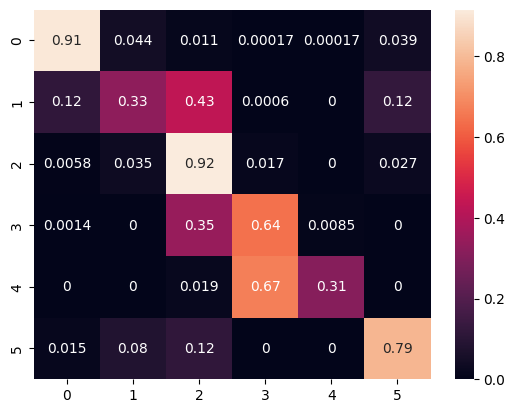

100%|█████████████████████████████████████████| 215/215 [00:02<00:00, 73.76it/s]
Epoch 1/10 - Train loss: 0.0327, score: 0.8526: 100%|█| 754/754 [01:51<00:00,  6
	  - Target loss: 0.0345, score: 0.8282: 100%|█| 129/129 [00:02<00:00, 63.91it/s
Epoch 2/10 - Train loss: 0.0310, score: 0.8625: 100%|█| 754/754 [01:51<00:00,  6
	  - Target loss: 0.0322, score: 0.8402: 100%|█| 129/129 [00:02<00:00, 62.35it/s
Epoch 3/10 - Train loss: 0.0300, score: 0.8665: 100%|█| 754/754 [01:52<00:00,  6
	  - Target loss: 0.0299, score: 0.8529: 100%|█| 129/129 [00:02<00:00, 63.33it/s
Epoch 4/10 - Train loss: 0.0294, score: 0.8715: 100%|█| 754/754 [01:51<00:00,  6
	  - Target loss: 0.0291, score: 0.8583: 100%|█| 129/129 [00:02<00:00, 61.96it/s
Epoch 5/10 - Train loss: 0.0287, score: 0.8756: 100%|█| 754/754 [01:51<00:00,  6
	  - Target loss: 0.0283, score: 0.8638: 100%|█| 129/129 [00:02<00:00, 62.94it/s
Epoch 6/10 - Train loss: 0.0283, score: 0.8766: 100%|█| 754/754 [01:51<00:00,  6
	  - Target loss: 0.0300, sc


###### PHASE 2 FINISHED ########OUTPUT_FOLDER##


	  - Target loss: 0.0267, score: 0.8708: 100%|█| 129/129 [00:02<00:00, 63.54it/s


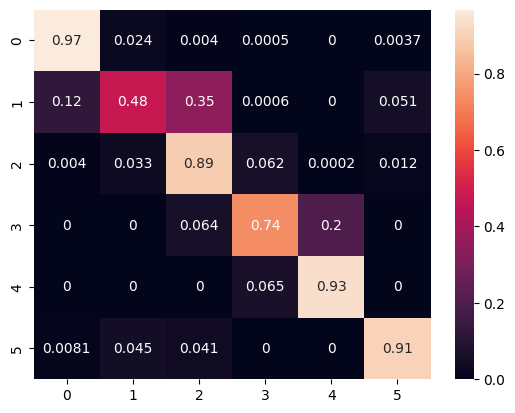

100%|█████████████████████████████████████████| 215/215 [00:02<00:00, 73.98it/s]
Epoch 1/20 - Train loss: 0.0724, score: 0.6712: 100%|█| 441/441 [01:03<00:00,  6
	  - Target loss: 0.0421, score: 0.8307: 100%|█| 129/129 [00:02<00:00, 63.09it/s
Epoch 2/20 - Train loss: 0.0687, score: 0.6731: 100%|█| 441/441 [01:03<00:00,  6
	  - Target loss: 0.0405, score: 0.8261: 100%|█| 129/129 [00:02<00:00, 62.79it/s
Epoch 3/20 - Train loss: 0.0679, score: 0.6751: 100%|█| 441/441 [01:03<00:00,  6
	  - Target loss: 0.0429, score: 0.7884: 100%|█| 129/129 [00:02<00:00, 61.49it/s
Epoch 4/20 - Train loss: 0.0670, score: 0.6765: 100%|█| 441/441 [01:03<00:00,  6
	  - Target loss: 0.0407, score: 0.8331: 100%|█| 129/129 [00:02<00:00, 62.71it/s
Epoch 5/20 - Train loss: 0.0653, score: 0.6856: 100%|█| 441/441 [01:03<00:00,  6
	  - Target loss: 0.0352, score: 0.8572: 100%|█| 129/129 [00:02<00:00, 63.12it/s
Epoch 6/20 - Train loss: 0.0638, score: 0.6910: 100%|█| 441/441 [01:03<00:00,  6
	  - Target loss: 0.0310, sc


###### PHASE 3 FINISHED ##########


	  - Target loss: 0.0078, score: 0.9789: 100%|█| 129/129 [00:02<00:00, 62.24it/s


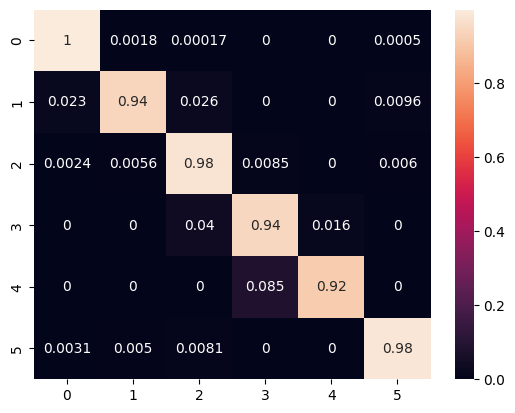

100%|█████████████████████████████████████████| 215/215 [00:02<00:00, 73.46it/s]
/tmp/ipykernel_415636/3885554587.py:111: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


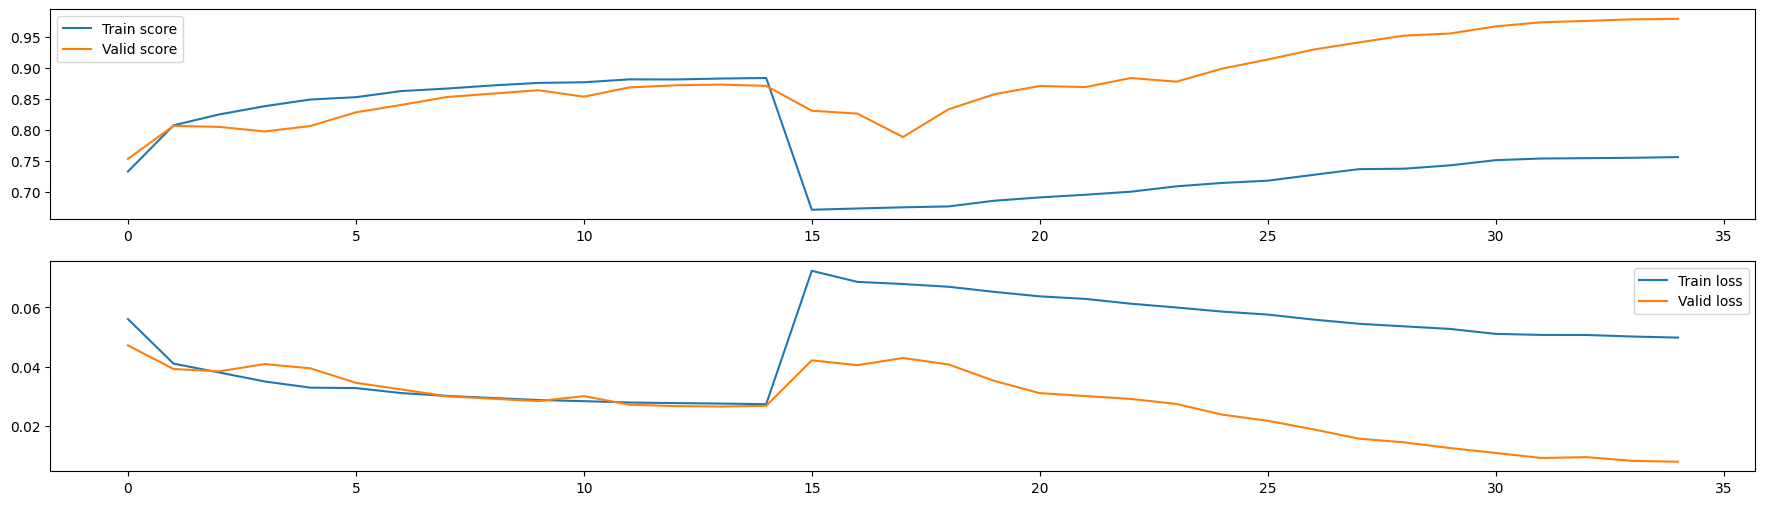

In [30]:
args_array = []
args = base_args("eeg-classifier_seed-42")
seed_everything(args.seed)
model = EEGClassifier()
supervised_run(args, model, source_data, source_labels, target_data, target_labels, test_data, mixup_data=mixup_data, supervised_mixup_data=supervised_mixup_data)
args_array.append(args)

{
    "alpha": 0.01,
    "batch_size": 120,
    "device": "cuda",
    "epochs": 5,
    "lr": 0.001,
    "model_name": "eeg-classifier_seed-2021",
    "num_workers": 2,
    "phase": "base",
    "seed": 2021
}


Epoch 1/5 - Train loss: 0.0571, score: 0.7235: 100%|█| 754/754 [01:53<00:00,  6.
	  - Target loss: 0.0435, score: 0.7718: 100%|█| 129/129 [00:02<00:00, 61.81it/s
Epoch 2/5 - Train loss: 0.0413, score: 0.8068: 100%|█| 754/754 [01:53<00:00,  6.
	  - Target loss: 0.0413, score: 0.7861: 100%|█| 129/129 [00:02<00:00, 61.45it/s
Epoch 3/5 - Train loss: 0.0377, score: 0.8239: 100%|█| 754/754 [01:53<00:00,  6.
	  - Target loss: 0.0387, score: 0.8053: 100%|█| 129/129 [00:02<00:00, 57.71it/s
Epoch 4/5 - Train loss: 0.0348, score: 0.8381: 100%|█| 754/754 [02:36<00:00,  4.
	  - Target loss: 0.0407, score: 0.7964: 100%|█| 129/129 [00:03<00:00, 33.80it/s
Epoch 5/5 - Train loss: 0.0327, score: 0.8497: 100%|█| 754/754 [03:29<00:00,  3.
	  - Target loss: 0.0403, score: 0.8018: 100%|█| 129/129 [00:03<00:00, 32.47it/s



###### PHASE 1 FINISHED ##########


	  - Target loss: 0.0403, score: 0.8018: 100%|█| 129/129 [00:03<00:00, 32.29it/s


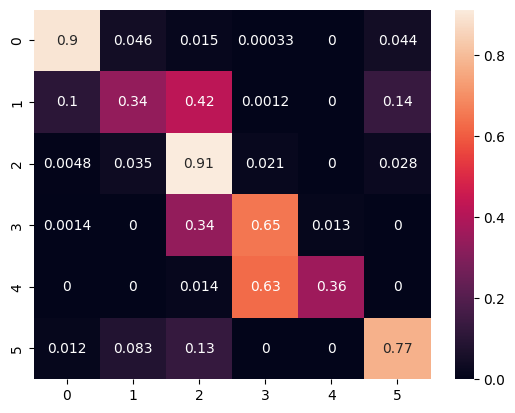

100%|█████████████████████████████████████████| 215/215 [00:05<00:00, 39.26it/s]
Epoch 1/10 - Train loss: 0.0329, score: 0.8509: 100%|█| 754/754 [03:45<00:00,  3
	  - Target loss: 0.0352, score: 0.8239: 100%|█| 129/129 [00:03<00:00, 32.78it/s
Epoch 2/10 - Train loss: 0.0310, score: 0.8617: 100%|█| 754/754 [03:45<00:00,  3
	  - Target loss: 0.0316, score: 0.8439: 100%|█| 129/129 [00:03<00:00, 32.77it/s
Epoch 3/10 - Train loss: 0.0299, score: 0.8680: 100%|█| 754/754 [03:45<00:00,  3
	  - Target loss: 0.0299, score: 0.8531: 100%|█| 129/129 [00:04<00:00, 31.97it/s
Epoch 4/10 - Train loss: 0.0295, score: 0.8708: 100%|█| 754/754 [03:46<00:00,  3
	  - Target loss: 0.0282, score: 0.8630: 100%|█| 129/129 [00:03<00:00, 32.81it/s
Epoch 5/10 - Train loss: 0.0289, score: 0.8733: 100%|█| 754/754 [03:45<00:00,  3
	  - Target loss: 0.0278, score: 0.8640: 100%|█| 129/129 [00:03<00:00, 32.75it/s
Epoch 6/10 - Train loss: 0.0281, score: 0.8791: 100%|█| 754/754 [03:45<00:00,  3
	  - Target loss: 0.0276, sc


###### PHASE 2 FINISHED ########OUTPUT_FOLDER##


	  - Target loss: 0.0264, score: 0.8707: 100%|█| 129/129 [00:03<00:00, 32.63it/s


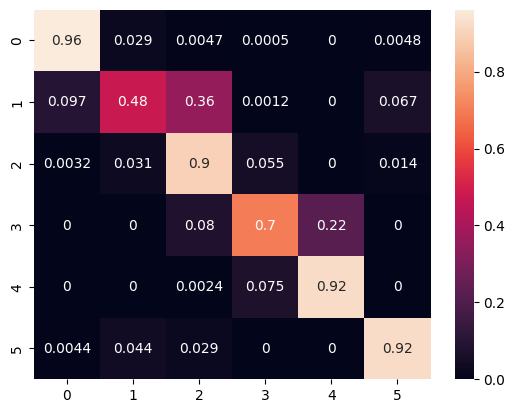

100%|█████████████████████████████████████████| 215/215 [00:05<00:00, 38.73it/s]
Epoch 1/20 - Train loss: 0.0723, score: 0.6711: 100%|█| 441/441 [02:10<00:00,  3
	  - Target loss: 0.0385, score: 0.8362: 100%|█| 129/129 [00:03<00:00, 32.34it/s
Epoch 2/20 - Train loss: 0.0698, score: 0.6706: 100%|█| 441/441 [02:10<00:00,  3
	  - Target loss: 0.0407, score: 0.8129: 100%|█| 129/129 [00:03<00:00, 32.65it/s
Epoch 3/20 - Train loss: 0.0678, score: 0.6724: 100%|█| 441/441 [02:10<00:00,  3
	  - Target loss: 0.0355, score: 0.8472: 100%|█| 129/129 [00:03<00:00, 32.32it/s
Epoch 4/20 - Train loss: 0.0664, score: 0.6786: 100%|█| 441/441 [02:10<00:00,  3
	  - Target loss: 0.0333, score: 0.8523: 100%|█| 129/129 [00:03<00:00, 32.66it/s
Epoch 5/20 - Train loss: 0.0652, score: 0.6849: 100%|█| 441/441 [02:10<00:00,  3
	  - Target loss: 0.0334, score: 0.8634: 100%|█| 129/129 [00:03<00:00, 32.66it/s
Epoch 6/20 - Train loss: 0.0637, score: 0.6873: 100%|█| 441/441 [02:09<00:00,  3
	  - Target loss: 0.0331, sc


###### PHASE 3 FINISHED ##########


	  - Target loss: 0.0082, score: 0.9751: 100%|█| 129/129 [00:03<00:00, 32.47it/s


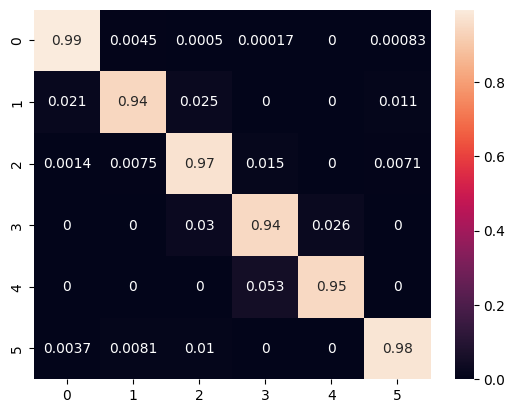

100%|█████████████████████████████████████████| 215/215 [00:05<00:00, 38.81it/s]
/tmp/ipykernel_415636/3885554587.py:111: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


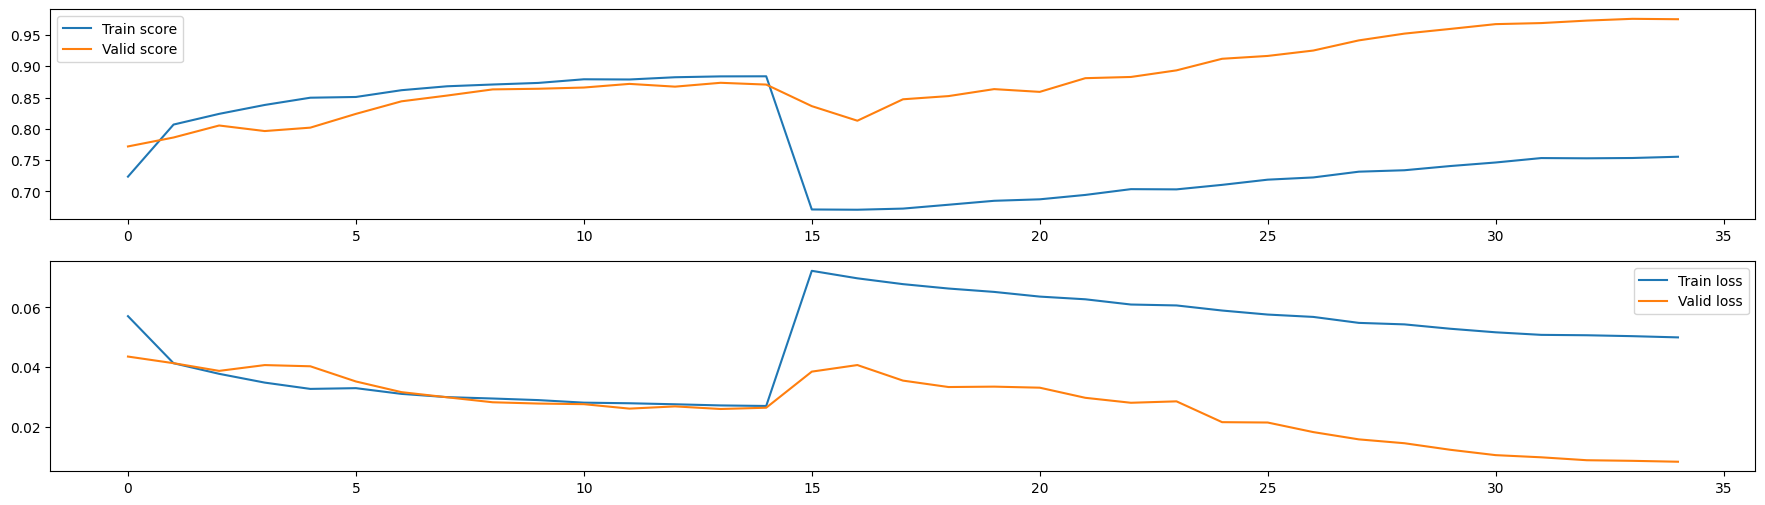

In [31]:
args = base_args("eeg-classifier_seed-2021", seed=2021)
seed_everything(args.seed)
model = EEGClassifier()
supervised_run(args, model, source_data, source_labels, target_data, target_labels, test_data, mixup_data=mixup_data, supervised_mixup_data=supervised_mixup_data)
args_array.append(args)

### ensemble predictions 

In [32]:
target_output = ensemble(args_array, "target", "base")
target_pred = np.argmax(target_output, axis=1)
print("Base model ensemble target accuracy: ", np.mean(target_pred == target_labels))

target_output = ensemble(args_array, "target", "mixup")
target_pred = np.argmax(target_output, axis=1)
print("Mixup model ensemble target accuracy: ", np.mean(target_pred == target_labels))

test_output = ensemble(args_array, "test")
test_pred = np.argmax(test_output, axis=1)
np.savetxt(f"{OUTPUT_FOLDER}answer_leader.txt", test_pred, delimiter=',',fmt="%d")

Base model ensemble target accuracy:  0.8052065794586194
Mixup model ensemble target accuracy:  0.8722315762206968


(array([ 5594.,     0.,   205.,     0., 18012.,     0.,   196.,     0.,
           76.,  1665.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

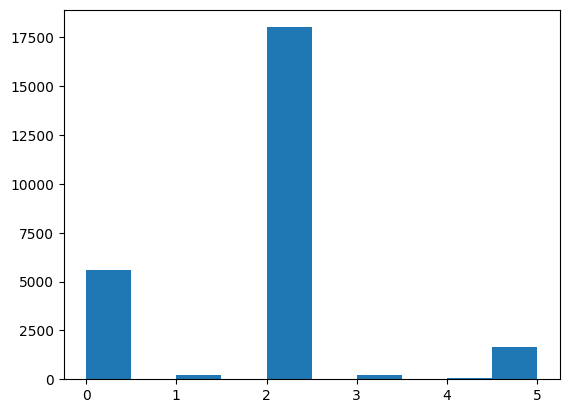

In [33]:
plt.hist(test_pred)

In [34]:
source_data, source_labels, target_data, target_labels, test_data, mixup_data = get_phase_2_data()

Loading data from folder: /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/SleepSource/ (157 files) - Load labels True


  0%|                                                   | 0/157 [00:00<?, ?it/s]

<Info | 8 non-empty values
 bads: []
 ch_names: Fpz-Cz, Pz-Oz
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1991-09-26 15:00:00 UTC
 nchan: 2
 projs: []
 sfreq: 100.0 Hz
 subject_info: 2 items (dict)
>


100%|█████████████████████████████████████████| 157/157 [00:38<00:00,  4.09it/s]


Loaded total 90545 samples for subjects: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2500.43it/s]


Loading data from folder: /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/LeaderboardSleep/sleep_target/ (25 files) - Load labels True


  0%|                                                    | 0/25 [00:00<?, ?it/s]

<Info | 8 non-empty values
 bads: []
 ch_names: Fpz-Cz, Pz-Oz
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1990-03-13 15:09:00 UTC
 nchan: 2
 projs: []
 sfreq: 100.0 Hz
 subject_info: 2 items (dict)
>


100%|███████████████████████████████████████████| 25/25 [00:06<00:00,  3.92it/s]


Loaded total 15442 samples for subjects: [0 1 2 3 4 5]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 1970.54it/s]


Source mean: -2.175762164676705e-07, std: 1.6836217270029333e-05, min: -14.7172265485441, max: 12.426637935405019
Loading data from folder: /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/LeaderboardSleep/testing/ (25 files) - Load labels False


100%|███████████████████████████████████████████| 25/25 [00:10<00:00,  2.31it/s]


Loaded total 25748 samples for subjects: [ 6  7  8  9 10 11 12 13 14 15 16 17]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 3801.48it/s]


Leadeboard test mean: 0.014119353426048422, std: 0.8645048345254686, min: -11.985021370728651, max: 11.832680288053835
Loading data from folder: /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/finalSleep/sleep_target/ (20 files) - Load labels True


100%|███████████████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Loaded total 16568 samples for subjects: [0 1 2 3 4]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 2572.56it/s]


Target mean: 0.031174427319106832, std: 0.9668677818534862, min: -11.866229841258413, max: 12.010867582259191
Loading data from folder: /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/finalSleep/testing/ (18 files) - Load labels False


100%|███████████████████████████████████████████| 18/18 [00:11<00:00,  1.54it/s]


Loaded total 25756 samples for subjects: [ 5  6  7  8  9 10 11 12 13]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 2658.36it/s]


Final test mean: 0.04296289931340894, std: 0.8598280113936251, min: -12.282000194404242, max: 11.713888758583598


In [35]:
tmp = np.array(target_data)
supervised_mixup_data = {}
for c in np.unique(target_labels):
    supervised_mixup_data[c] = tmp[target_labels == c]
    print(c, np.shape(supervised_mixup_data[c]))

del tmp

0 (13819, 2, 3000)
1 (3311, 2, 3000)
2 (9739, 2, 3000)
3 (1393, 2, 3000)
4 (559, 2, 3000)
5 (3189, 2, 3000)


{
    "alpha": 0.01,
    "batch_size": 120,
    "device": "cuda",
    "epochs": 5,
    "lr": 0.001,
    "model_name": "eeg-classifier_seed-42",
    "num_workers": 2,
    "phase": "base",
    "seed": 42
}


Epoch 1/5 - Train loss: 0.0563, score: 0.7323: 100%|█| 754/754 [01:52<00:00,  6.
	  - Target loss: 0.0466, score: 0.7557: 100%|█| 267/267 [00:05<00:00, 53.13it/s
Epoch 2/5 - Train loss: 0.0410, score: 0.8074: 100%|█| 754/754 [01:51<00:00,  6.
	  - Target loss: 0.0407, score: 0.7952: 100%|█| 267/267 [00:04<00:00, 59.71it/s
Epoch 3/5 - Train loss: 0.0380, score: 0.8241: 100%|█| 754/754 [01:51<00:00,  6.
	  - Target loss: 0.0405, score: 0.8002: 100%|█| 267/267 [00:04<00:00, 58.40it/s
Epoch 4/5 - Train loss: 0.0351, score: 0.8360: 100%|█| 754/754 [01:52<00:00,  6.
	  - Target loss: 0.0404, score: 0.8037: 100%|█| 267/267 [00:04<00:00, 59.36it/s
Epoch 5/5 - Train loss: 0.0330, score: 0.8481: 100%|█| 754/754 [01:51<00:00,  6.
	  - Target loss: 0.0395, score: 0.8093: 100%|█| 267/267 [00:04<00:00, 58.21it/s



###### PHASE 1 FINISHED ##########


	  - Target loss: 0.0395, score: 0.8093: 100%|█| 267/267 [00:04<00:00, 58.06it/s


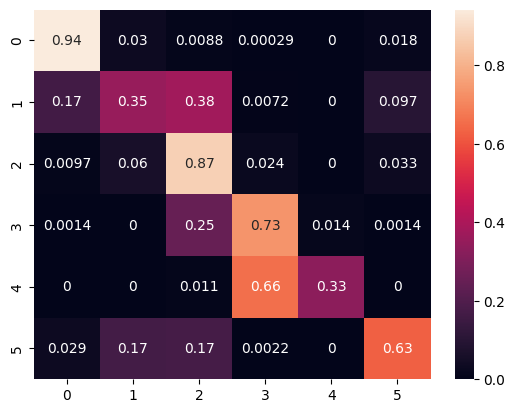

100%|█████████████████████████████████████████| 215/215 [00:02<00:00, 72.63it/s]
Epoch 1/10 - Train loss: 0.0346, score: 0.8439: 100%|█| 754/754 [01:54<00:00,  6
	  - Target loss: 0.0375, score: 0.8126: 100%|█| 267/267 [00:07<00:00, 36.80it/s
Epoch 2/10 - Train loss: 0.0327, score: 0.8531: 100%|█| 754/754 [02:08<00:00,  5
	  - Target loss: 0.0342, score: 0.8281: 100%|█| 267/267 [00:07<00:00, 35.04it/s
Epoch 3/10 - Train loss: 0.0323, score: 0.8555: 100%|█| 754/754 [02:10<00:00,  5
	  - Target loss: 0.0327, score: 0.8380: 100%|█| 267/267 [00:08<00:00, 33.30it/s
Epoch 4/10 - Train loss: 0.0316, score: 0.8590: 100%|█| 754/754 [02:10<00:00,  5
	  - Target loss: 0.0343, score: 0.8274: 100%|█| 267/267 [00:07<00:00, 37.24it/s
Epoch 5/10 - Train loss: 0.0311, score: 0.8629: 100%|█| 754/754 [02:08<00:00,  5
	  - Target loss: 0.0322, score: 0.8378: 100%|█| 267/267 [00:07<00:00, 35.59it/s
Epoch 6/10 - Train loss: 0.0307, score: 0.8636: 100%|█| 754/754 [02:07<00:00,  5
	  - Target loss: 0.0325, sc


###### PHASE 2 FINISHED ########OUTPUT_FOLDER##


	  - Target loss: 0.0304, score: 0.8480: 100%|█| 267/267 [00:08<00:00, 33.23it/s


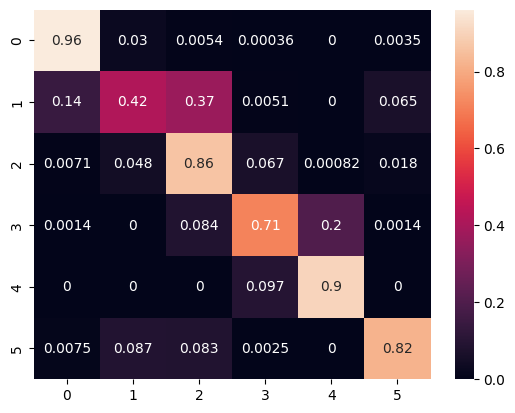

100%|█████████████████████████████████████████| 215/215 [00:03<00:00, 63.48it/s]
Epoch 1/20 - Train loss: 0.0647, score: 0.7111: 100%|█| 510/510 [01:22<00:00,  6
	  - Target loss: 0.0430, score: 0.8065: 100%|█| 267/267 [00:07<00:00, 34.50it/s
Epoch 2/20 - Train loss: 0.0621, score: 0.7076: 100%|█| 510/510 [01:22<00:00,  6
	  - Target loss: 0.0378, score: 0.8273: 100%|█| 267/267 [00:07<00:00, 33.71it/s
Epoch 3/20 - Train loss: 0.0609, score: 0.7100: 100%|█| 510/510 [01:22<00:00,  6
	  - Target loss: 0.0371, score: 0.8404: 100%|█| 267/267 [00:07<00:00, 35.21it/s
Epoch 4/20 - Train loss: 0.0589, score: 0.7184: 100%|█| 510/510 [01:23<00:00,  6
	  - Target loss: 0.0394, score: 0.8219: 100%|█| 267/267 [00:08<00:00, 33.15it/s
Epoch 5/20 - Train loss: 0.0567, score: 0.7261: 100%|█| 510/510 [01:57<00:00,  4
	  - Target loss: 0.0349, score: 0.8317: 100%|█| 267/267 [00:09<00:00, 29.05it/s
Epoch 6/20 - Train loss: 0.0552, score: 0.7331: 100%|█| 510/510 [02:16<00:00,  3
	  - Target loss: 0.0333, sc


###### PHASE 3 FINISHED ##########


	  - Target loss: 0.0111, score: 0.9621: 100%|█| 267/267 [00:08<00:00, 32.41it/s


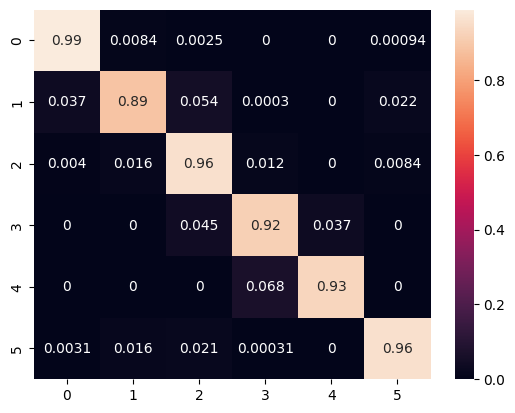

100%|█████████████████████████████████████████| 215/215 [00:05<00:00, 38.57it/s]
/tmp/ipykernel_415636/3885554587.py:111: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


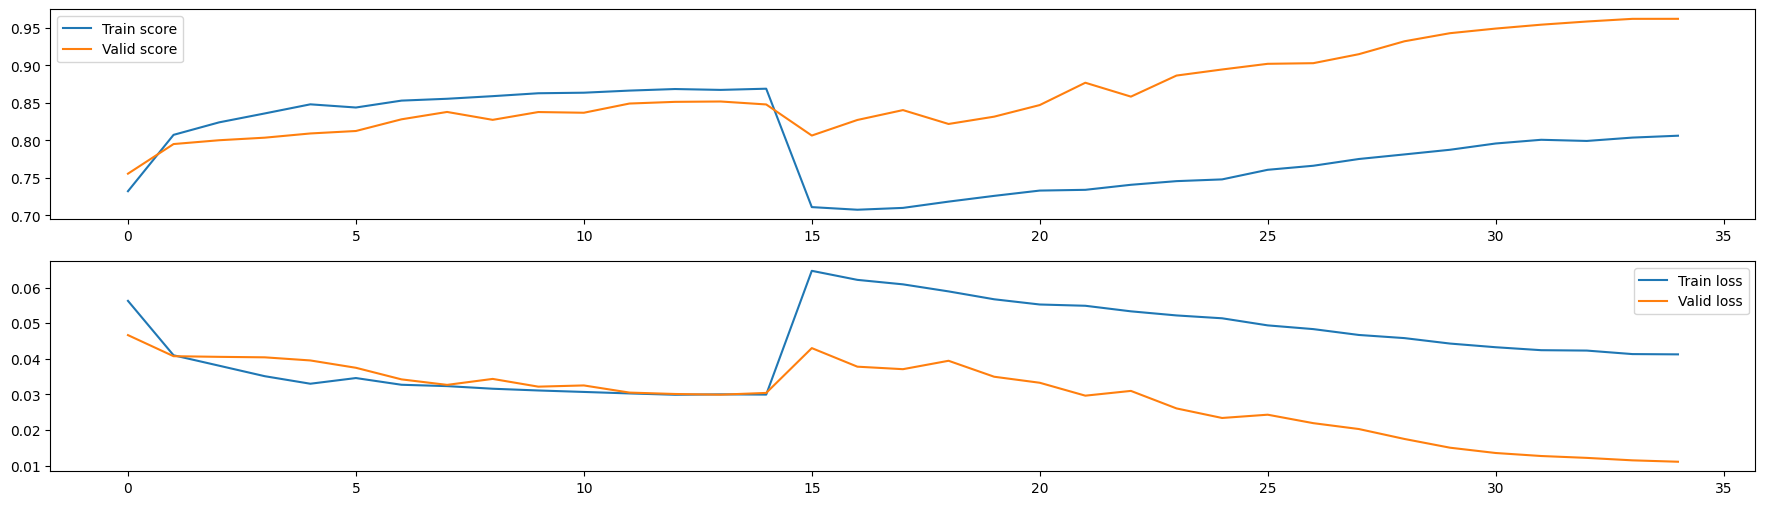

In [36]:
args_array = []
args = base_args("eeg-classifier_seed-42")
seed_everything(args.seed)
model = EEGClassifier()
supervised_run(args, model, source_data, source_labels, target_data, target_labels, test_data, mixup_data=mixup_data, supervised_mixup_data=supervised_mixup_data)
args_array.append(args)

{
    "alpha": 0.01,
    "batch_size": 120,
    "device": "cuda",
    "epochs": 5,
    "lr": 0.001,
    "model_name": "eeg-classifier_seed-2021",
    "num_workers": 2,
    "phase": "base",
    "seed": 2021
}


Epoch 1/5 - Train loss: 0.0570, score: 0.7268: 100%|█| 754/754 [03:44<00:00,  3.
	  - Target loss: 0.0437, score: 0.7786: 100%|█| 267/267 [00:08<00:00, 31.34it/s
Epoch 2/5 - Train loss: 0.0415, score: 0.8051: 100%|█| 754/754 [03:44<00:00,  3.
	  - Target loss: 0.0420, score: 0.7825: 100%|█| 267/267 [00:08<00:00, 31.86it/s
Epoch 3/5 - Train loss: 0.0378, score: 0.8229: 100%|█| 754/754 [03:44<00:00,  3.
	  - Target loss: 0.0401, score: 0.7943: 100%|█| 267/267 [00:08<00:00, 31.33it/s
Epoch 4/5 - Train loss: 0.0349, score: 0.8372: 100%|█| 754/754 [03:44<00:00,  3.
	  - Target loss: 0.0411, score: 0.7984: 100%|█| 267/267 [00:08<00:00, 31.40it/s
Epoch 5/5 - Train loss: 0.0328, score: 0.8494: 100%|█| 754/754 [03:44<00:00,  3.
	  - Target loss: 0.0405, score: 0.8012: 100%|█| 267/267 [00:08<00:00, 31.78it/s



###### PHASE 1 FINISHED ##########


	  - Target loss: 0.0405, score: 0.8012: 100%|█| 267/267 [00:08<00:00, 31.27it/s


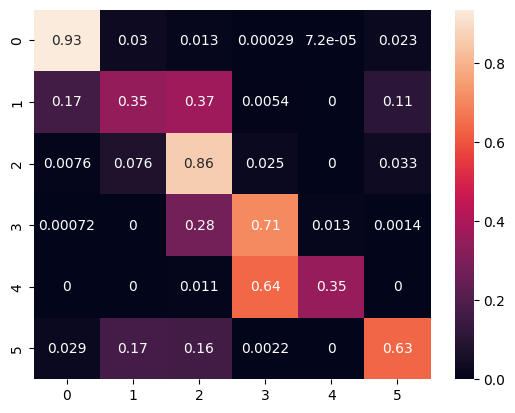

100%|█████████████████████████████████████████| 215/215 [00:05<00:00, 39.87it/s]
Epoch 1/10 - Train loss: 0.0344, score: 0.8434: 100%|█| 754/754 [03:43<00:00,  3
	  - Target loss: 0.0360, score: 0.8189: 100%|█| 267/267 [00:08<00:00, 31.93it/s
Epoch 2/10 - Train loss: 0.0329, score: 0.8522: 100%|█| 754/754 [03:44<00:00,  3
	  - Target loss: 0.0346, score: 0.8296: 100%|█| 267/267 [00:08<00:00, 31.64it/s
Epoch 3/10 - Train loss: 0.0319, score: 0.8571: 100%|█| 754/754 [03:44<00:00,  3
	  - Target loss: 0.0322, score: 0.8386: 100%|█| 267/267 [00:08<00:00, 32.21it/s
Epoch 4/10 - Train loss: 0.0316, score: 0.8588: 100%|█| 754/754 [03:44<00:00,  3
	  - Target loss: 0.0317, score: 0.8419: 100%|█| 267/267 [00:08<00:00, 31.25it/s
Epoch 5/10 - Train loss: 0.0310, score: 0.8619: 100%|█| 754/754 [03:44<00:00,  3
	  - Target loss: 0.0308, score: 0.8466: 100%|█| 267/267 [00:08<00:00, 31.73it/s
Epoch 6/10 - Train loss: 0.0304, score: 0.8639: 100%|█| 754/754 [03:44<00:00,  3
	  - Target loss: 0.0315, sc


###### PHASE 2 FINISHED ########OUTPUT_FOLDER##


	  - Target loss: 0.0302, score: 0.8482: 100%|█| 267/267 [00:08<00:00, 31.87it/s


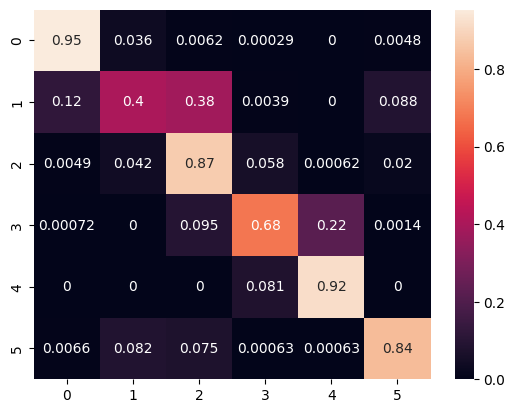

100%|█████████████████████████████████████████| 215/215 [00:05<00:00, 38.73it/s]
Epoch 1/20 - Train loss: 0.0638, score: 0.7156: 100%|█| 510/510 [02:29<00:00,  3
	  - Target loss: 0.0380, score: 0.8383: 100%|█| 267/267 [00:08<00:00, 31.09it/s
Epoch 2/20 - Train loss: 0.0621, score: 0.7075: 100%|█| 510/510 [02:29<00:00,  3
	  - Target loss: 0.0448, score: 0.7919: 100%|█| 267/267 [00:08<00:00, 31.50it/s
Epoch 3/20 - Train loss: 0.0597, score: 0.7152: 100%|█| 510/510 [02:29<00:00,  3
	  - Target loss: 0.0400, score: 0.8229: 100%|█| 267/267 [00:08<00:00, 31.43it/s
Epoch 4/20 - Train loss: 0.0587, score: 0.7166: 100%|█| 510/510 [02:30<00:00,  3
	  - Target loss: 0.0342, score: 0.8451: 100%|█| 267/267 [00:08<00:00, 31.53it/s
Epoch 5/20 - Train loss: 0.0570, score: 0.7262: 100%|█| 510/510 [02:30<00:00,  3
	  - Target loss: 0.0337, score: 0.8479: 100%|█| 267/267 [00:08<00:00, 31.03it/s
Epoch 6/20 - Train loss: 0.0561, score: 0.7274: 100%|█| 510/510 [02:29<00:00,  3
	  - Target loss: 0.0334, sc


###### PHASE 3 FINISHED ##########


	  - Target loss: 0.0116, score: 0.9615: 100%|█| 267/267 [00:04<00:00, 57.79it/s


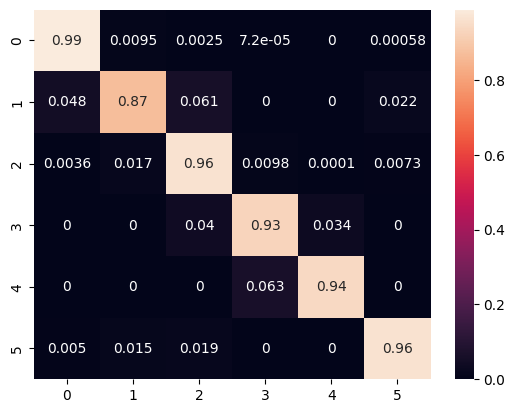

100%|█████████████████████████████████████████| 215/215 [00:02<00:00, 73.65it/s]
/tmp/ipykernel_415636/3885554587.py:111: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


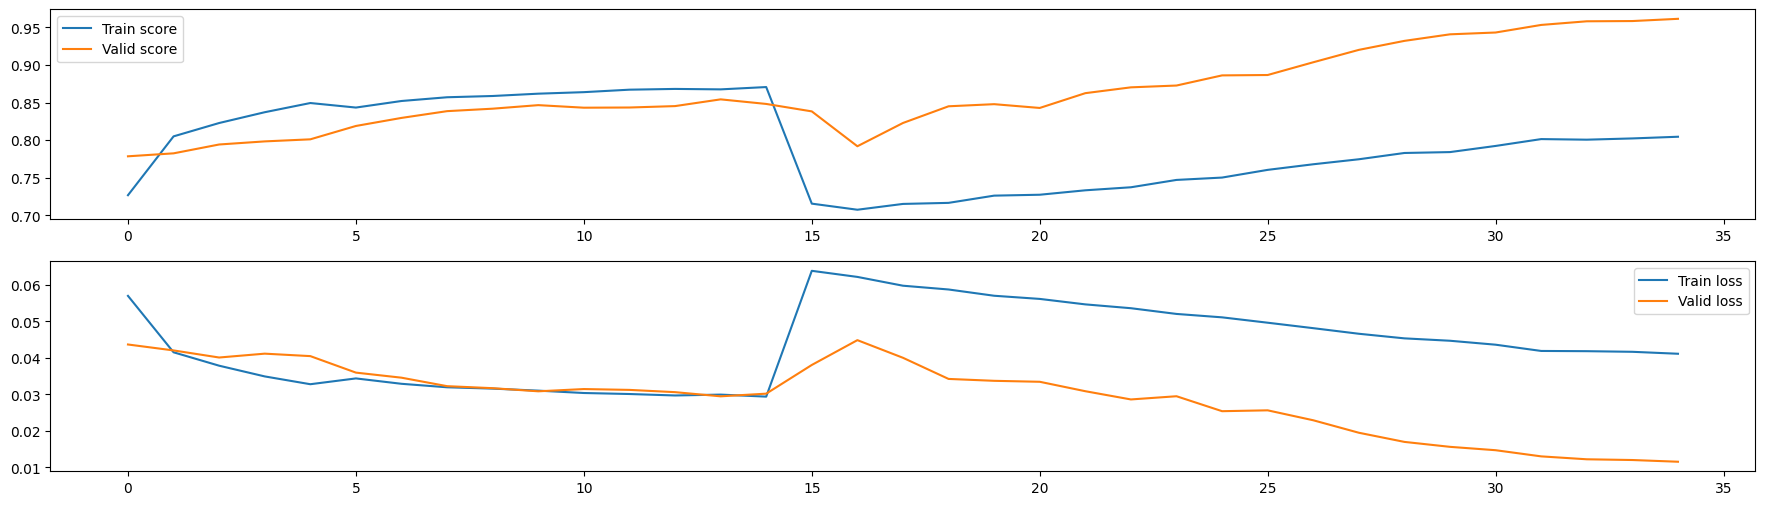

In [37]:
args = base_args("eeg-classifier_seed-2021", seed=2021)
seed_everything(args.seed)
model = EEGClassifier()
supervised_run(args, model, source_data, source_labels, target_data, target_labels, test_data, mixup_data=mixup_data, supervised_mixup_data=supervised_mixup_data)
args_array.append(args)

In [38]:
target_output = ensemble(args_array, "target", "base")
target_pred = np.argmax(target_output, axis=1)
print("Base model ensemble target accuracy: ", np.mean(target_pred == target_labels))

target_output = ensemble(args_array, "target", "mixup")
target_pred = np.argmax(target_output, axis=1)
print("Mixup model ensemble target accuracy: ", np.mean(target_pred == target_labels))

test_output = ensemble(args_array, "test")
test_pred = np.argmax(test_output, axis=1)
np.savetxt(f"{OUTPUT_FOLDER}answer_final.txt", test_pred, delimiter=',',fmt="%d")

Base model ensemble target accuracy:  0.8077788191190253
Mixup model ensemble target accuracy:  0.8512652296157451


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def load_and_evaluate(predictions_file, ground_truth_file, output_folder):
    # Load predictions and ground truth from text files
    try:
        with open(predictions_file, 'r') as file:
            predictions = [int(line.strip()) for line in file]

        with open(ground_truth_file, 'r') as file:
            ground_truth = [int(line.strip()) for line in file]

    except Exception as e:
        print(f"Error reading files: {e}")
        return

    # Check if lengths of predictions and ground truth match
    if len(predictions) != len(ground_truth):
        print("Error: The number of predictions and ground truth labels do not match.")
        return

    # Convert lists to numpy arrays for compatibility with scikit-learn
    y_pred = np.array(predictions)
    y_true = np.array(ground_truth)

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multiclass
    recall = recall_score(y_true, y_pred, average='weighted')        # Use 'weighted' for multiclass
    f1 = f1_score(y_true, y_pred, average='weighted')                # Use 'weighted' for multiclass

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot and save confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d')
    
    # Save confusion matrix to the output folder
    cm_image_path = f"{output_folder}/confusion_matrix.png"
    plt.savefig(cm_image_path)
    plt.show()
    plt.close()

    print(f"Confusion matrix has been saved as an image at {cm_image_path}.")


# # Example usage
# predictions_file = OUTPUT_FOLDER+'answer_leader.txt'
# ground_truth_file = '/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/EEGSleepLatest/Sleep_Data/leaderboardOriginal.txt'
# load_and_evaluate(predictions_file, ground_truth_file, OUTPUT_FOLDER)


Accuracy: 0.5111
Precision: 0.5199
Recall: 0.5111
F1 Score: 0.4503


<Figure size 800x600 with 0 Axes>

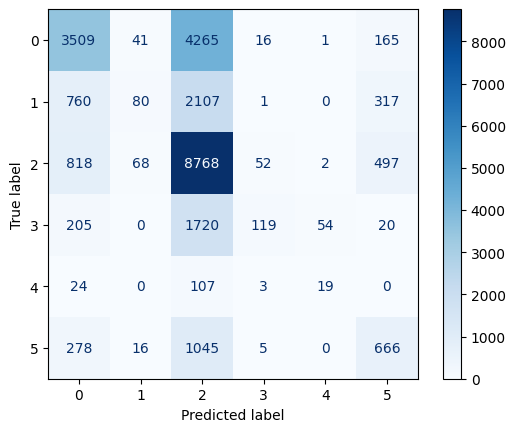

Confusion matrix has been saved as an image at /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/residual_full_mixup/outputs_residual_full_mixup/confusion_matrix.png.


In [40]:
# Example usage
predictions_file = OUTPUT_FOLDER+'answer_leader.txt'
ground_truth_file = '/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/leaderboardOriginal.txt'
load_and_evaluate(predictions_file, ground_truth_file, OUTPUT_FOLDER)

Accuracy: 0.3857
Precision: 0.5826
Recall: 0.3857
F1 Score: 0.3461


<Figure size 800x600 with 0 Axes>

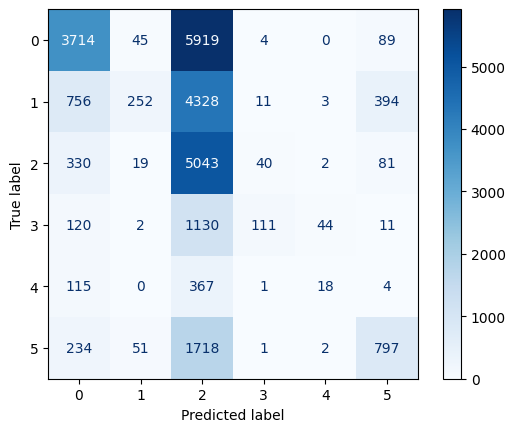

Confusion matrix has been saved as an image at /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/residual_full_mixup/outputs_residual_full_mixup/confusion_matrix.png.


In [41]:
# Example usage
predictions_file = OUTPUT_FOLDER+'answer_final.txt'
ground_truth_file = '/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/LeaderboardSleep/final_pred_sleep_label_example.txt'
load_and_evaluate(predictions_file, ground_truth_file, OUTPUT_FOLDER)